<h2>1.使用autoencoder降维</h2>

In [1]:
!pip install numpy==1.26.0
!pip install tensorflow==2.18.0
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
# 导入需要用到的库
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2024-11-29 20:21:28.868910: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 20:21:28.872478: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 20:21:28.883489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732882888.902060   27203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732882888.907509   27203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 20:21:28.926768: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
#读取数据
data_path = '/personal/作业/pbmc_data.csv'
df = pd.read_csv(data_path)
# 显示数据的前几行，以了解其结构
df.head()

,Unnamed: 0,TNFRSF4,CPSF3L,ATAD3C,C1orf86,RER1,TNFRSF25,TNFRSF9,CTNNBIP1,SRM,...,BACE2,SIK1,C21orf33,ICOSLG,SUMO3,SLC19A1,S100B,PRMT2,cell_type,cell_type_string
0,AAACATACAACCAC-1,-0.171470,-0.280812,-0.046677,-0.475169,-0.544024,4.928497,-0.038028,-0.280573,-0.341788,...,-0.102943,-0.222116,-0.312401,-0.121678,-0.521229,-0.098269,-0.209095,-0.531203,0,CD4 T
1,AAACATTGAGCTAC-1,-0.214582,-0.372653,-0.054804,-0.683391,0.633951,-0.334837,-0.045589,-0.498264,-0.541914,...,0.007155,-0.445372,1.629285,-0.058662,-0.857163,-0.266844,-0.313146,-0.596654,2,B
2,AAACATTGATCAGC-1,-0.376888,-0.295085,-0.057527,-0.520972,1.332648,-0.309362,-0.103108,-0.272526,-0.500799,...,-0.071774,-0.297857,-0.410920,-0.070431,-0.590720,-0.158656,-0.170876,1.379000,0,CD4 T
3,AAACCGTGCTTCCG-1,-0.285241,-0.281735,-0.052227,-0.484929,1.572680,-0.271825,-0.074552,-0.258875,-0.416752,...,-0.093818,-0.247770,2.552079,-0.097402,1.631684,-0.119462,-0.179120,-0.505669,1,CD14 Monocytes
4,AAACCGTGTATGCG-1,-0.256484,-0.220394,-0.046800,-0.345859,-0.333409,-0.208122,-0.069514,5.806440,-0.283112,...,-0.167350,-0.098665,-0.275836,-0.139482,-0.310095,-0.006877,-0.109614,-0.461946,4,NK


In [4]:
#统计每类细胞的个数
cell_type_counts = df['cell_type'].value_counts()
print(cell_type_counts)

0    1148
1     486
2     341
3     303
4     160
5     151
6      36
7      13
Name: cell_type, dtype: int64


In [5]:
# 获取基因数据
gene_columns = df.columns[1:-2]
data = df[gene_columns].values
#获取细胞类型数据
cell_types = df.iloc[:, -2].values  # 取出细胞类型（数字格式）
cell_type_names = df.iloc[:, -1].values  # 取出细胞类型名称

In [6]:
#查看数据
data

array([[-0.17146961, -0.2808123 , -0.04667677, ..., -0.09826882,
        -0.20909512, -0.5312033 ],
       [-0.21458235, -0.37265328, -0.05480441, ..., -0.266844  ,
        -0.31314582, -0.5966543 ],
       [-0.3768877 , -0.29508454, -0.05752748, ..., -0.15865591,
        -0.17087644,  1.3789997 ],
       ...,
       [-0.20708963, -0.2504642 , -0.04639699, ..., -0.05114426,
        -0.16106427,  2.041497  ],
       [-0.1903285 , -0.2263338 , -0.04399936, ..., -0.00591774,
        -0.13521305, -0.48211104],
       [-0.33378935, -0.25358772, -0.05271561, ..., -0.07842438,
        -0.13032718, -0.47133783]])

In [7]:
cell_types

array([0, 2, 0, ..., 2, 2, 0])

In [8]:
cell_type_names

array(['CD4 T', 'B', 'CD4 T', ..., 'B', 'B', 'CD4 T'], dtype=object)

In [9]:
# 标准化数据
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

In [29]:
normalized_data

array([[-1.71502118e-01, -2.82811393e-01, -4.95847576e-02, ...,
        -1.02943420e-01, -2.09219372e-01, -5.31304011e-01],
       [-2.14623032e-01, -3.75601345e-01, -6.44721541e-02, ...,
        -2.92965037e-01, -3.13369714e-01, -5.96767419e-01],
       [-3.76959154e-01, -2.97231105e-01, -6.94600088e-02, ...,
        -1.71013064e-01, -1.70964093e-01,  1.37926114e+00],
       ...,
       [-2.07128892e-01, -2.52149714e-01, -4.90722697e-02, ...,
        -4.98235895e-02, -1.61142527e-01,  2.04188405e+00],
       [-1.90364584e-01, -2.27769980e-01, -4.46805365e-02, ...,
         1.15672885e-03, -1.35266551e-01, -4.82202443e-01],
       [-3.33852633e-01, -2.55305508e-01, -6.06460922e-02, ...,
        -8.05743353e-02, -1.30376003e-01, -4.71427191e-01]])

In [41]:
# 设置autoencoder的结构尺寸
input_dim = normalized_data.shape[1]
encoding_dim = 2  # 降维后的维度设为2，以便可视化

In [81]:
# 定义encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(256, activation='relu')(input_layer)
encoder = Dense(128, activation='relu')(encoder)
encoder_output = Dense(encoding_dim, activation='relu')(encoder)

In [82]:
# 定义decoder
decoder = Dense(128, activation='relu')(encoder_output)
decoder = Dense(256, activation='relu')(decoder)
decoder_output = Dense(input_dim, activation='softmax')(decoder)

In [83]:
# 构建autoencoder模型
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

In [84]:
# 编译模型
autoencoder.compile(optimizer=Adam(learning_rate=0.000054), loss='binary_crossentropy')

In [85]:
# 训练模型
autoencoder.fit(normalized_data, normalized_data, epochs=18, batch_size=256, shuffle=True)

Epoch 1/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.6931
Epoch 2/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6912
Epoch 3/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6866
Epoch 4/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6761
Epoch 5/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6563
Epoch 6/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6217
Epoch 7/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5700
Epoch 8/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4990
Epoch 9/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4107
Epoch 10/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3160
Epoch 11/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2243
Epoch 12/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1482
Epoch 13/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0931
Epoch 14/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0552
Epoch 15/18
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0259
Epoc

In [86]:
# 构建encoder模型
encoder_model = Model(inputs=input_layer, outputs=encoder_output)

In [87]:
# 使用encoder模型对数据进行降维
encoded_data = encoder_model.predict(normalized_data)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [88]:
# 将降维后的数据保存到csv文件中
encoded_df = pd.DataFrame(encoded_data, columns=['Dim1', 'Dim2'])
encoded_df['CellType'] = cell_types
encoded_df['CellTypeName'] = cell_type_names
encoded_df.to_csv('encoded_pbmc_gene_expression.csv', index=False)

In [89]:
encoded_data.shape

(2638, 2)

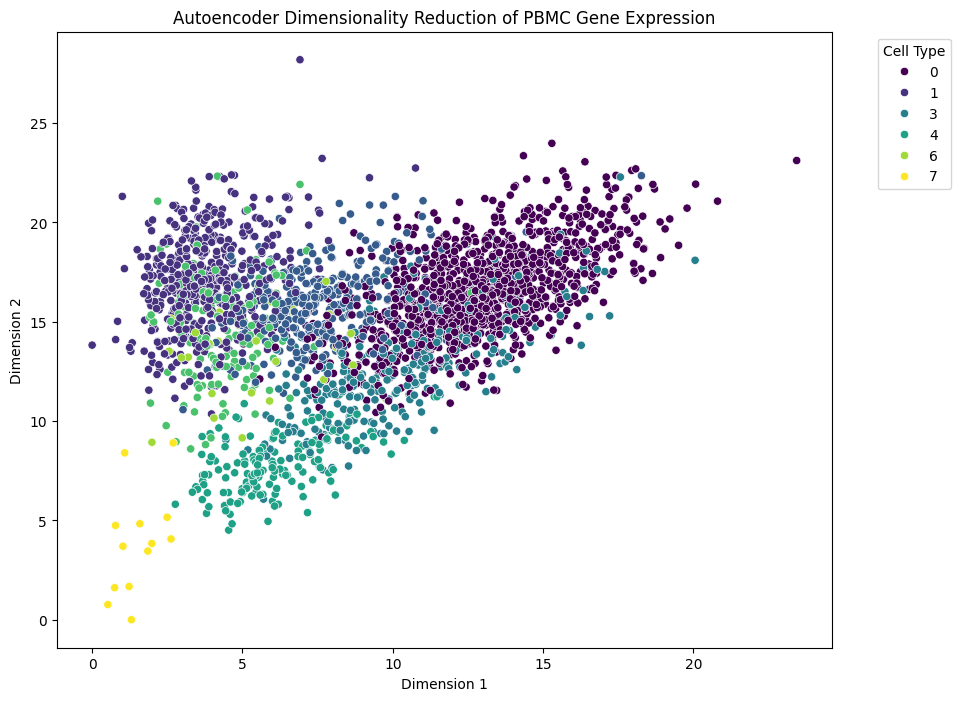

In [90]:
# 可视化降维后的数据
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dim1', y='Dim2', hue='CellType', data=encoded_df, palette='viridis')
plt.title('Autoencoder Dimensionality Reduction of PBMC Gene Expression')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<h2>2. 构建神经网络模型，通过细胞的基因表达预测细胞的类型</h2>

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add,Activation, Dense, BatchNormalization, Input

In [92]:
#搭建baseline model
model1 = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='softmax')
])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

/opt/mamba/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 128)            │       235,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,936 (956.78 KB)

 Trainable params: 244,552 (955.28 KB)

 Non-trainable params: 384 (1.50 KB)

In [107]:
#增加网络宽度
model2 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dense(128, activation='relu'),  
    BatchNormalization(),
    Dense(8, activation='softmax')
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

/opt/mamba/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 256)            │       470,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,248 (1.93 MB)

 Trainable params: 505,480 (1.93 MB)

 Non-trainable params: 768 (3.00 KB)

In [110]:
#增加网络深度
model3 = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='softmax')
])

model3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

/opt/mamba/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 128)            │       235,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,352 (966.22 KB)

 Trainable params: 246,872 (964.34 KB)

 Non-trainable params: 480 (1.88 KB)

In [111]:
#改变优化器的超参数
model4 = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='softmax')
])

model4.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.8), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 128)            │       235,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,936 (956.78 KB)

 Trainable params: 244,552 (955.28 KB)

 Non-trainable params: 384 (1.50 KB)

In [112]:
#添加resnet层
def residual_block(x, filters):
    # 主路径
    main_path = BatchNormalization()(x)
    main_path = Activation('relu')(main_path)
    main_path = Dense(filters)(main_path)
    
    main_path = BatchNormalization()(main_path)
    main_path = Activation('relu')(main_path)
    main_path = Dense(filters)(main_path)
    
    # 捷径路径
    shortcut_path = BatchNormalization()(x)
    shortcut_path = Activation('relu')(shortcut_path)
    shortcut_path = Dense(filters)(shortcut_path)
    
    # 合并主路径和捷径路径
    output = Add()([main_path, shortcut_path])
    output = Activation('relu')(output)
    
    return output

input_layer = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(input_layer)
x = residual_block(x, 128)
output_layer = Dense(8, activation='softmax')(x)

model5 = Model(inputs=input_layer, outputs=output_layer)

model5.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1838)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 128)       │    235,392 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_83[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 128)       │     16,512 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_84[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_83[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 128)       │     16,512 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 128)       │     16,512 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128)       │          0 │ dense_85[0][0],   │
│                     │                   │            │ dense_86[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 128)       │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 8)         │      1,032 │ activation_11[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 287,496 (1.10 MB)

 Trainable params: 286,728 (1.09 MB)

 Non-trainable params: 768 (3.00 KB)

In [113]:
#增加resnet的filters
x1 = Dense(256, activation='relu')(input_layer)
x1 = residual_block(x, 256)
output_layer = Dense(8, activation='softmax')(x1)

model6 = Model(inputs=input_layer, outputs=output_layer)

model6.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model6.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1838)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 128)       │    235,392 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_83[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 128)       │     16,512 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_84[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_83[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 128)       │     16,512 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 128)       │     16,512 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128)       │          0 │ dense_85[0][0],   │
│                     │                   │            │ dense_86[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 128)       │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ activation_11[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 256)       │     33,024 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_89[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ activation_11[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 422,408 (1.61 MB)

 Trainable params: 420,616 (1.60 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 假设X是基因表达数据，y是细胞类型的标签
X_train, X_test, y_train, y_test = train_test_split(normalized_data, cell_types, test_size=0.2, random_state=42)

In [114]:
#给每个模型设置名称
model1.name = 'Model_1'
model2.name = 'Model_2'
model3.name = 'Model_3'
model4.name = 'Model_4'
model5.name = 'Model_5'
model6.name = 'Model_6'

In [105]:
# 训练模型并记录损失和准确率---模型1
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

# 评估模型
loss, accuracy = model1.evaluate(X_test, y_test)
predictions = model.predict(X_test)
predictions_class = predictions.argmax(axis=-1)
y_test_class = y_test.argmax(axis=-1) if len(y_test.shape) > 1 else y_test

# 打印评估结果
print(f"Model: {model1.name}, Test Accuracy: {accuracy}, Loss: {loss}")
print(confusion_matrix(y_test_class, predictions_class))
print(classification_report(y_test_class, predictions_class))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 4.4060e-04 - val_accuracy: 0.9336 - val_loss: 0.2262
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.1146e-04 - val_accuracy: 0.9336 - val_loss: 0.2265
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.3721e-04 - val_accuracy: 0.9336 - val_loss: 0.2262
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.1677e-04 - val_accuracy: 0.9336 - val_loss: 0.2262
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.2498e-04 - val_accuracy: 0.9336 - val_loss: 0.2261
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.4538e-04 - val_accuracy: 0.9336 - val_loss: 0.2259
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.0304e-04 - val_accuracy: 0.9336 - val_loss: 0.2260
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.9854e-04 - val_accu

In [109]:
# 训练模型并记录损失和准确率---模型2
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

# 评估模型
loss, accuracy = model2.evaluate(X_test, y_test)
predictions = model2.predict(X_test)
predictions_class = predictions.argmax(axis=-1)
y_test_class = y_test.argmax(axis=-1) if len(y_test.shape) > 1 else y_test

# 打印评估结果
print(f"Model: {model2.name}, Test Accuracy: {accuracy}, Loss: {loss}")
print(confusion_matrix(y_test_class, predictions_class))
print(classification_report(y_test_class, predictions_class))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3322 - loss: 2.0515 - val_accuracy: 0.5782 - val_loss: 1.2311
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9696 - loss: 0.2220 - val_accuracy: 0.7630 - val_loss: 0.8192
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9973 - loss: 0.0557 - val_accuracy: 0.8294 - val_loss: 0.6433
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9992 - loss: 0.0292 - val_accuracy: 0.8531 - val_loss: 0.5432
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 0.8673 - val_loss: 0.4809
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.8673 - val_loss: 0.4365
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 0.8863 - val_loss: 0.3988
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.8957 - val_loss: 0.3676


In [115]:
# 训练模型并记录损失和准确率---模型3
history3 = model3.fit(X_train, y_train, epochs=40, batch_size=256, validation_split=0.1)

# 评估模型
loss, accuracy = model3.evaluate(X_test, y_test)
predictions = model3.predict(X_test)
predictions_class = predictions.argmax(axis=-1)
y_test_class = y_test.argmax(axis=-1) if len(y_test.shape) > 1 else y_test

# 打印评估结果
print(f"Model: {model3.name}, Test Accuracy: {accuracy}, Loss: {loss}")
print(confusion_matrix(y_test_class, predictions_class))
print(classification_report(y_test_class, predictions_class))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1333 - loss: 2.3427 - val_accuracy: 0.1137 - val_loss: 2.0327
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5049 - loss: 1.3733 - val_accuracy: 0.2227 - val_loss: 1.8581
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7269 - loss: 1.0644 - val_accuracy: 0.3934 - val_loss: 1.7007
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8440 - loss: 0.8962 - val_accuracy: 0.5640 - val_loss: 1.5657
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9348 - loss: 0.7365 - val_accuracy: 0.6256 - val_loss: 1.4562
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9710 - loss: 0.6125 - val_accuracy: 0.7014 - val_loss: 1.3608
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9814 - loss: 0.5150 - val_accuracy: 0.7346 - val_loss: 1.2691
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9879 - loss: 0.4562 - val_accuracy: 0.8009 - val_loss: 1.1766


In [116]:
# 训练模型并记录损失和准确率---模型4
history4 = model4.fit(X_train, y_train, epochs=42, batch_size=256, validation_split=0.1)

# 评估模型
loss, accuracy = model4.evaluate(X_test, y_test)
predictions = model4.predict(X_test)
predictions_class = predictions.argmax(axis=-1)
y_test_class = y_test.argmax(axis=-1) if len(y_test.shape) > 1 else y_test

# 打印评估结果
print(f"Model: {model4.name}, Test Accuracy: {accuracy}, Loss: {loss}")
print(confusion_matrix(y_test_class, predictions_class))
print(classification_report(y_test_class, predictions_class))

Epoch 1/42
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2365 - loss: 2.2163 - val_accuracy: 0.5640 - val_loss: 1.2614
Epoch 2/42
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8847 - loss: 0.5920 - val_accuracy: 0.7014 - val_loss: 0.9100
Epoch 3/42
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9902 - loss: 0.2448 - val_accuracy: 0.7583 - val_loss: 0.7725
Epoch 4/42
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9995 - loss: 0.1294 - val_accuracy: 0.7915 - val_loss: 0.6991
Epoch 5/42
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0791 - val_accuracy: 0.8152 - val_loss: 0.6443
Epoch 6/42
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0549 - val_accuracy: 0.8341 - val_loss: 0.5986
Epoch 7/42
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0435 - val_accuracy: 0.8483 - val_loss: 0.5586
Epoch 8/42
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0329 - val_accuracy: 0.8626 - val_loss: 0.5270


In [117]:
# 训练模型并记录损失和准确率---模型5
history5 = model5.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

# 评估模型
loss, accuracy = model5.evaluate(X_test, y_test)
predictions = model5.predict(X_test)
predictions_class = predictions.argmax(axis=-1)
y_test_class = y_test.argmax(axis=-1) if len(y_test.shape) > 1 else y_test

# 打印评估结果
print(f"Model: {model5.name}, Test Accuracy: {accuracy}, Loss: {loss}")
print(confusion_matrix(y_test_class, predictions_class))
print(classification_report(y_test_class, predictions_class))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3560 - loss: 1.7782 - val_accuracy: 0.7678 - val_loss: 0.9413
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8858 - loss: 0.4904 - val_accuracy: 0.8104 - val_loss: 0.6606
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9761 - loss: 0.1736 - val_accuracy: 0.8720 - val_loss: 0.4625
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9960 - loss: 0.0677 - val_accuracy: 0.9005 - val_loss: 0.3698
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0276 - val_accuracy: 0.9052 - val_loss: 0.3296
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.9005 - val_loss: 0.3174
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.9100 - val_loss: 0.3040
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9052 - val_loss: 0.2922


In [118]:
# 训练模型并记录损失和准确率---模型6
history6 = model6.fit(X_train, y_train, epochs=40, batch_size=256, validation_split=0.1)

# 评估模型
loss, accuracy = model6.evaluate(X_test, y_test)
predictions = model6.predict(X_test)
predictions_class = predictions.argmax(axis=-1)
y_test_class = y_test.argmax(axis=-1) if len(y_test.shape) > 1 else y_test

# 打印评估结果
print(f"Model: {model6.name}, Test Accuracy: {accuracy}, Loss: {loss}")
print(confusion_matrix(y_test_class, predictions_class))
print(classification_report(y_test_class, predictions_class))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5766 - loss: 1.4296 - val_accuracy: 0.8720 - val_loss: 0.4247
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9942 - loss: 0.0272 - val_accuracy: 0.9100 - val_loss: 0.3221
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.9100 - val_loss: 0.2971
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 6.7474e-04 - val_accuracy: 0.9100 - val_loss: 0.2899
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 3.3878e-04 - val_accuracy: 0.9100 - val_loss: 0.2833
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 2.6044e-04 - val_accuracy: 0.9100 - val_loss: 0.2767
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 1.5695e-04 - val_accuracy: 0.9100 - val_loss: 0.2698
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 1.5784e-04 - val_accuracy: 0.9100

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


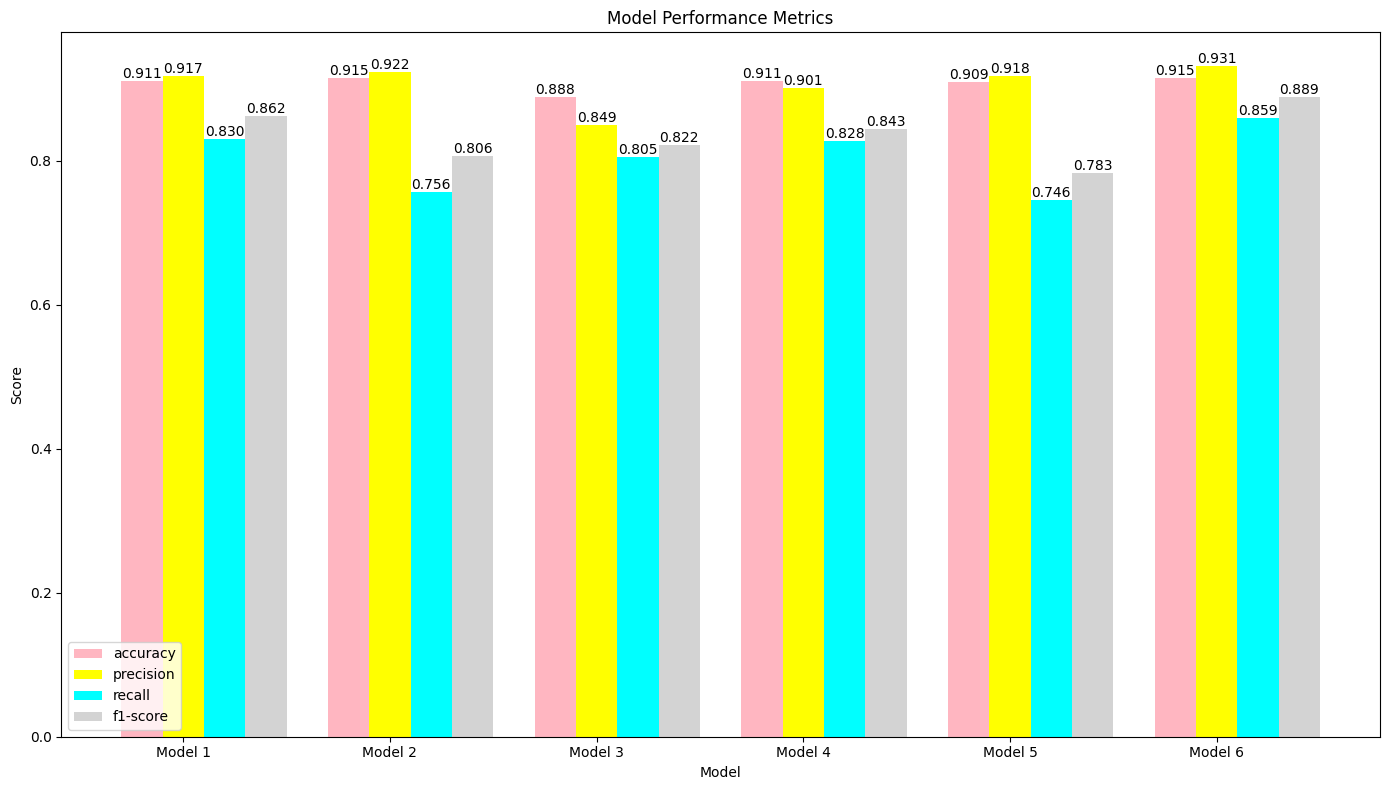

In [120]:
def plot_performance_metrics(models, names, X_test, y_test_class):
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    results = {metric: [] for metric in metrics}
    colors = ['lightpink', 'yellow', 'cyan', 'lightgrey']

    # 为每个模型计算性能指标
    for model, name in zip(models, names):
        y_pred = model.predict(X_test)
        y_pred_class = y_pred.argmax(axis=-1)
        report = classification_report(y_test_class, y_pred_class, output_dict=True)
        for metric in metrics:
            # 由于precision, recall, f1-score在classification_report中是针对每个类的，我们取macro average值
            if metric in ['precision', 'recall', 'f1-score']:
                results[metric].append(report['macro avg'][metric])
            else:
                results[metric].append(report['accuracy'])

    # 设置条形图的宽度和位置
    bar_width = 0.2
    indices = np.arange(len(names))

    # 绘制条形图
    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(metrics):
        plt.bar(indices + i * bar_width, [results[metric][j] for j in range(len(names))], bar_width, color=colors[i], label=metric)
    # 在每个柱子上方标出数值
    for i, metric in enumerate(metrics):
        for j, name in enumerate(names):
            height = results[metric][j]
            plt.text(indices[j] + i * bar_width, height, f'{height:.3f}', ha='center', va='bottom')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance Metrics')
    plt.xticks(indices + bar_width, names)
    plt.legend()
    plt.tight_layout()  # 调整布局以防止标签被截断
    plt.show()

# 绘制性能指标图
plot_performance_metrics([model1, model2, model3, model4, model5, model6], ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'], X_test, y_test_class)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


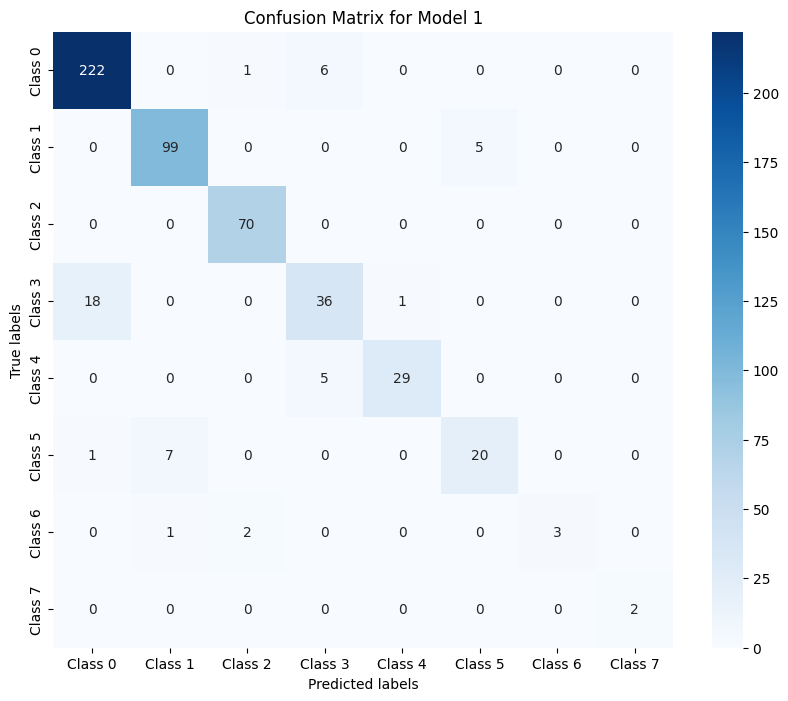

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


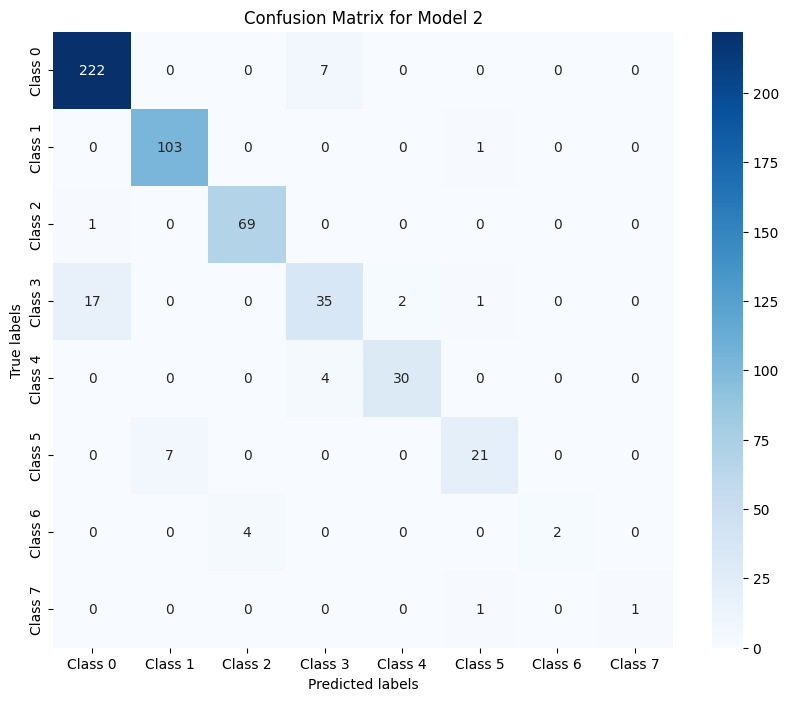

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


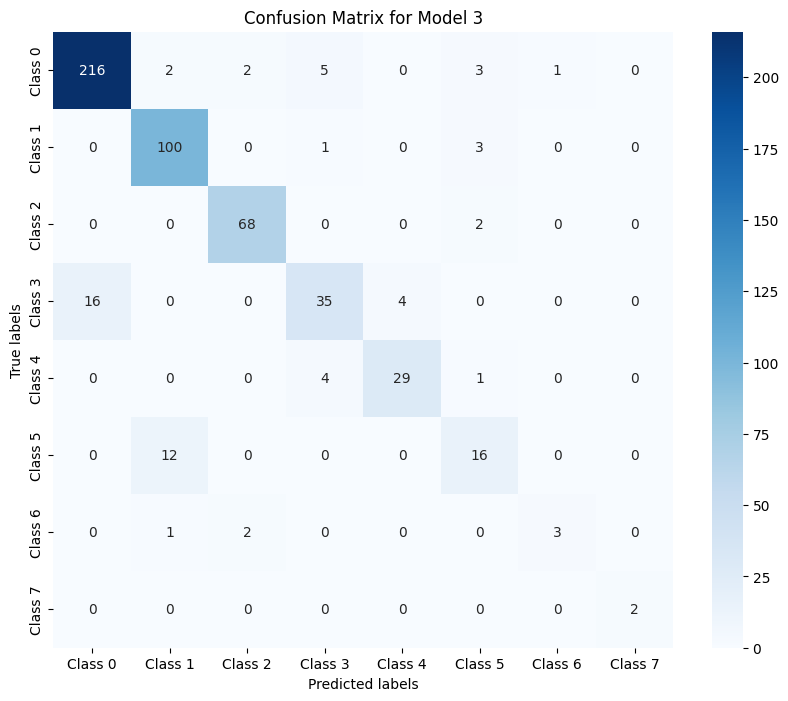

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


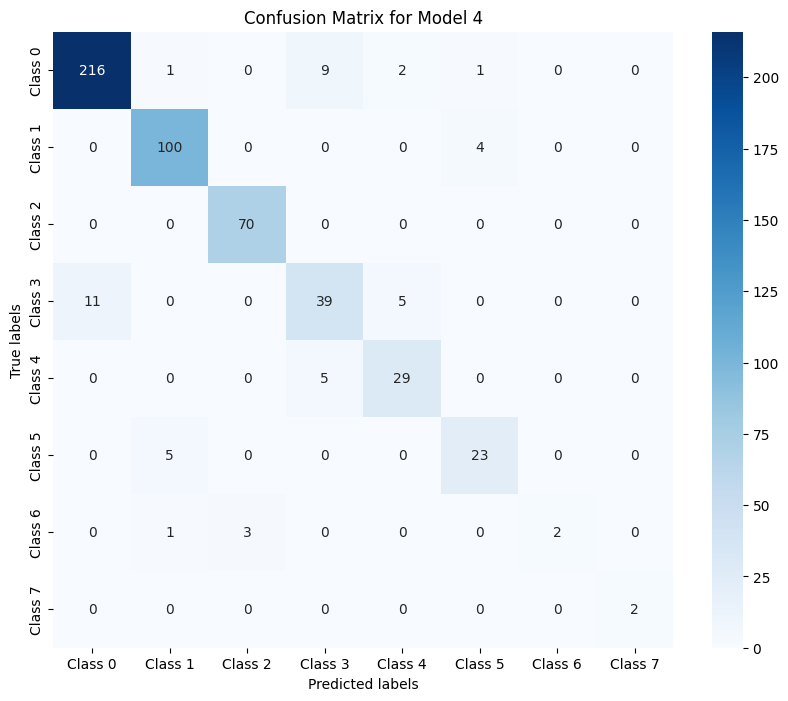

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


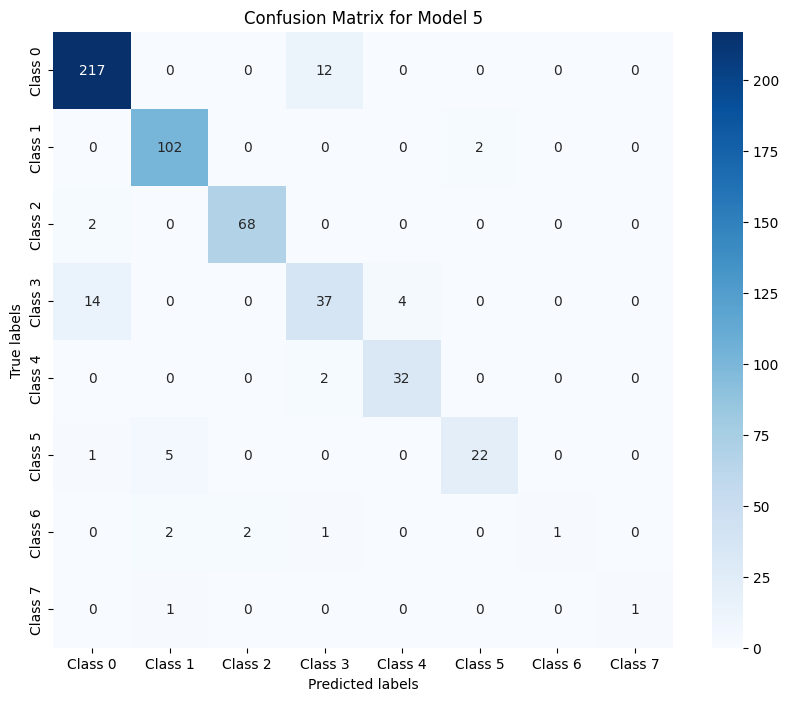

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


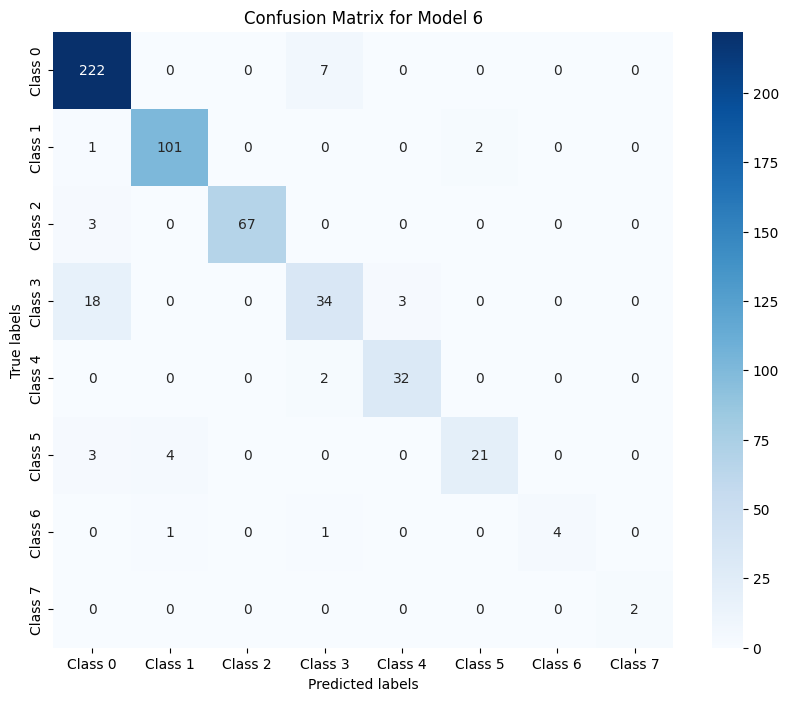

In [121]:
#绘制混淆矩阵
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, y_test, y_test_class, class_names, model_name):
    predictions = model.predict(X_test)
    predictions_class = predictions.argmax(axis=-1)
    cm = confusion_matrix(y_test_class, predictions_class)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# 获取所有类别的名称
class_names = [f'Class {i}' for i in range(8)]

# 为每个模型绘制混淆矩阵
for model, name in zip([model1, model2, model3, model4,model5,model6], ['Model 1', 'Model 2', 'Model 3', 'Model 4','Model 5', 'Model 6']):
    plot_confusion_matrix(model, X_test, y_test_class, class_names, name)

<h2>模型评估与比较</h2>

以模型1为基准模型，分别增加神经网络的宽度、深度、调整优化器参数、添加残差层、增加残差层的filter，共生成6个模型。使用6个模型分别进行训练和比较，并使用macro准确率、精准率、召回率、F1-score和混淆矩阵评估模型。

在多分类问题中，模型的性能评估不仅仅依赖于单一的指标，而是需要综合多个指标来全面理解模型的表现。本次实验的单细胞数据集是不平衡数据集，统计细胞类型的数量可以发现第0类细胞数量很多，但是第6、7类细胞数量较少。在多分类问题中，使用宏观（macro）平均来计算精确率、召回率和F1-score可以提供一个不偏不倚的性能评估，这种方法将所有类别视为同等重要，通过对每个类别的指标分别计算后取平均值，避免了数据集中类别不平衡问题对整体评估结果的影响。宏观平均不依赖于任何一个类别的样本数量，因此对于那些样本量较小的类别也能给予足够的关注，确保模型在所有类别上都有一定的泛化能力，因此适用于本次实验的不平衡数据集。混淆矩阵提供了一个详细的预测结果概览，展示了模型可能混淆的细胞类型，有助于进一步识别模型的弱点和改进方向。

**准确率:**
由指标对比图，所有模型当中，模型2和模型6的准确率最高，约为0.915.与基准模型模型1对比，即在原模型基础上增加模型宽度，或添加残差层之后增加模型宽度，都将有效提升模型的准确率.模型3的准确率最低，即增加神经网络的层数之后模型准确率下降。观察混淆矩阵发现主要原因为模型3对第1类细胞的预测准确率明显下降，导致整体准确率下降。可能原因为增加网络深度之后模型泛化能力下降。

**精准率：**
模型6最高，为0.931，模型3最低，为0.849.增加模型深度后准确率大幅下降，说明增加神经网络层数可能导致过拟合，使得模型在训练集上学习到噪声而非潜在的数据分布，从而在验证集或测试集上表现为精确率下降。

**召回率：**
模型6最高，为0.859，模型5最低，为0.746.与模型1相比，模型2、3、4、5更改超参数后召回率均有所下降，可能是因为模型复杂度增加导致过拟合，而模型6中增加残差层和filter有助于提升模型的表达能力，使模型能够更好地学习数据特征，从而提高召回率。

**F1 score：**
F1-score是精确率和召回率的调和平均值，增加模型宽度和深度可能导致过拟合，使得模型在训练集上表现良好但在验证集上泛化能力下降，从而导致F1-score下降；而添加残差层并增加filter有助于改善特征传递和网络训练稳定性，提升模型的泛化能力，因此F1-score得到提升。

**结论：**
综合评估模型6的性能最佳，4项指标均为所有模型当中最高，即原始模型通过增加网络宽度和添加残差模块，综合性能均得到提升。其中召回率提升幅度最大，约增加0.3，有效减少漏检。模型5的综合性能最差，说明如果仅添加残差层而不调整相关超参数，可能会导致模型预测能力下降。\\

添加残差层并调整合适参数之后可以改善模型的综合表现，主要原因为：1.残差层通过引入跳跃连接（skip connections）帮助梯度直接流向更深的层，从而缓解梯度消失问题。2.残差层允许网络中的信息和梯度更有效地流动，有助于特征在网络中的传递，提升深层网络的特征学习能力。3.残差层可以增加模型的容量，允许模型学习更复杂的特征表示，而不仅仅是简单的线性或非线性变换。4.残差层有助于模型在训练集上学习到更一般化的特征，从而提高模型在未见过的数据上的泛化能力。5.残差层可以通过恒等映射有效减少过拟合。